---

# DATA EDA

---

# IMPORT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

---
# DATA 불러오기 및 변수 설명

In [2]:
df = pd.read_csv("data/jeon2024.csv", encoding='cp949')
df.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일사(MJ/m2)
0,146,전주,2023-01-01 00:00,-0.9,NaN,1.4,72.0,NaN
1,146,전주,2023-01-01 01:00,-1.3,NaN,1.5,74.0,NaN
2,146,전주,2023-01-01 02:00,-1.7,NaN,1.4,75.0,NaN
3,146,전주,2023-01-01 03:00,-2.0,NaN,1.2,77.0,NaN
4,146,전주,2023-01-01 04:00,-2.0,NaN,1.7,79.0,NaN


In [3]:
df.shape

(8760, 8)

- 칼럼 : 지점, 지점명, 일시, 기온, 강수량, 풍속, 습도, 일사량
- 행 : 데이터 개수
- 차원 : $R^{n \times m}, \quad n = 1,...,8760, \quad m = 1,...,8$
- 약속 : $y = \text{일사량}, x=\text{일사량을 제외한 외생 변수들}$

In [4]:
df.isna().sum(axis=0)

지점              0
지점명             0
일시              0
기온(°C)          2
강수량(mm)      7583
풍속(m/s)         5
습도(%)           0
일사(MJ/m2)    3970
dtype: int64

- 결측치
    - 강수량은 결측치가 매우 많음
    - 일사량은 밤에는 측정이 되지 않음
    - 측정이 되지 않은 것이므로 결측치는 0으로 보간

---
# plot 시도표, 전체기간

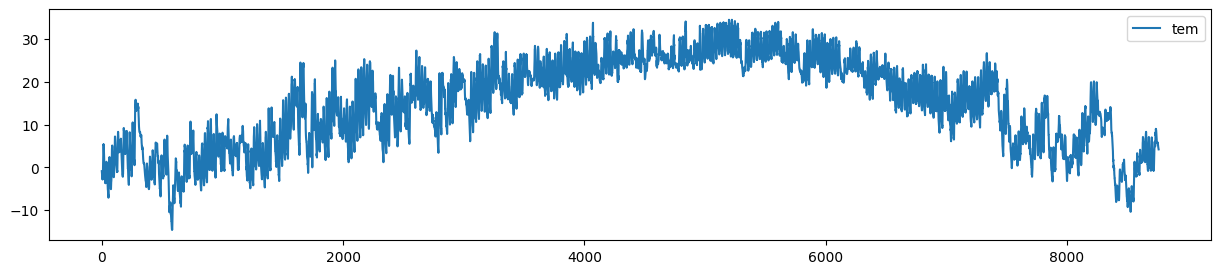

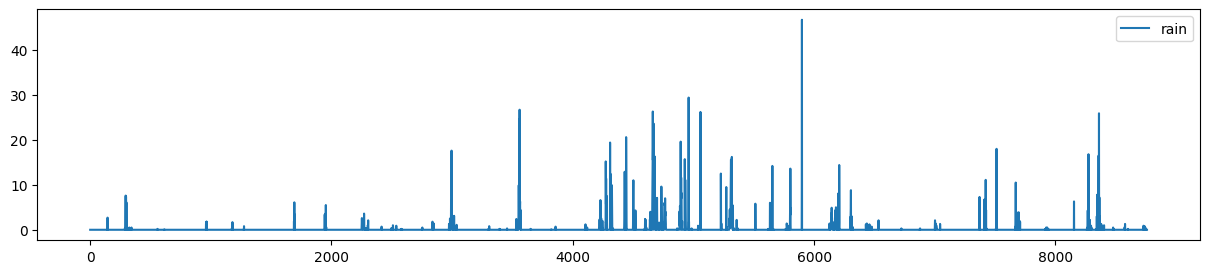

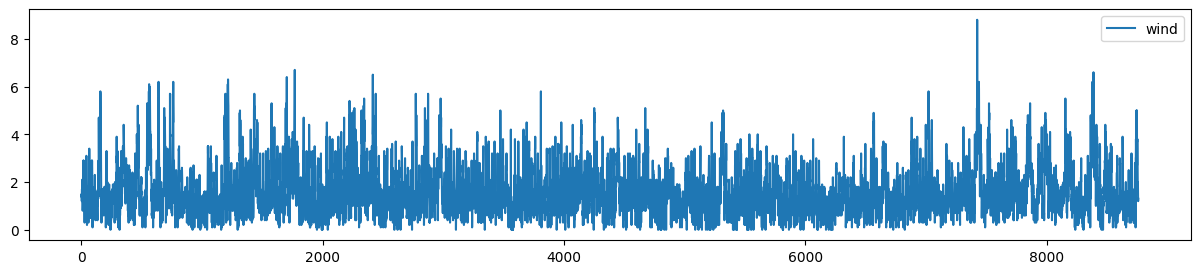

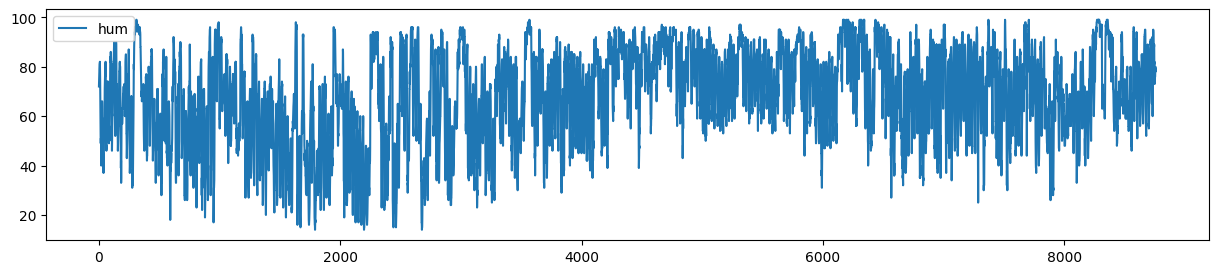

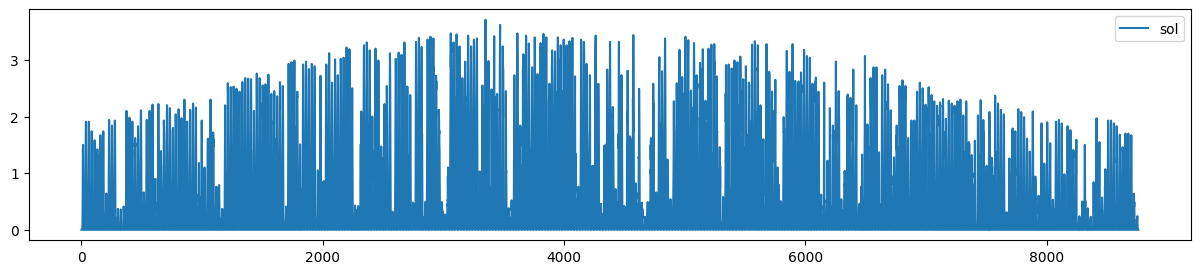

In [5]:
dff = df.iloc[:,2:].fillna(0)
dff.columns = ['date', 'tem', 'rain', 'wind', 'hum', 'sol']

for i in range(5):
    dff.iloc[:,[i+1]].plot(figsize=(15, 3));

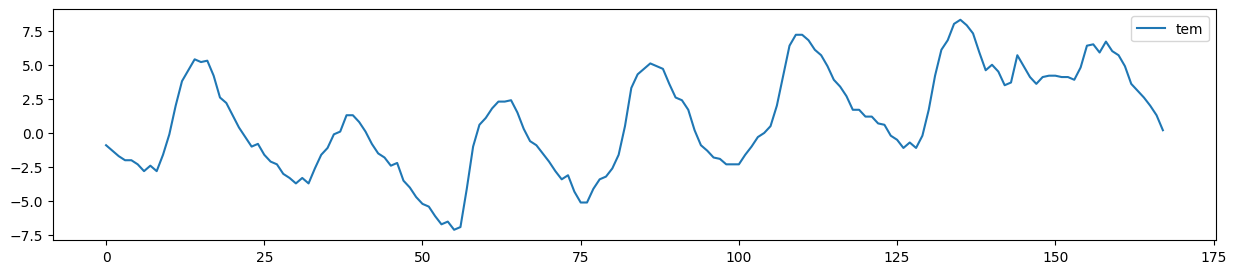

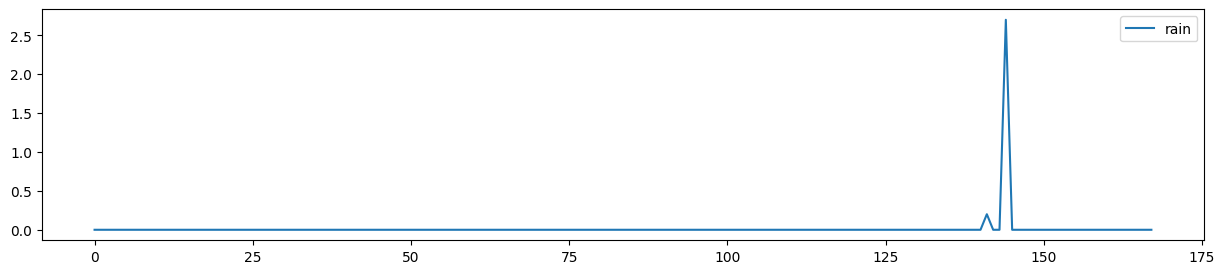

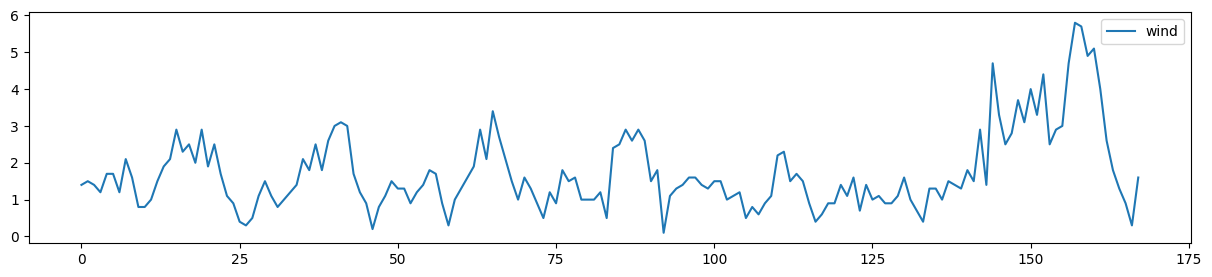

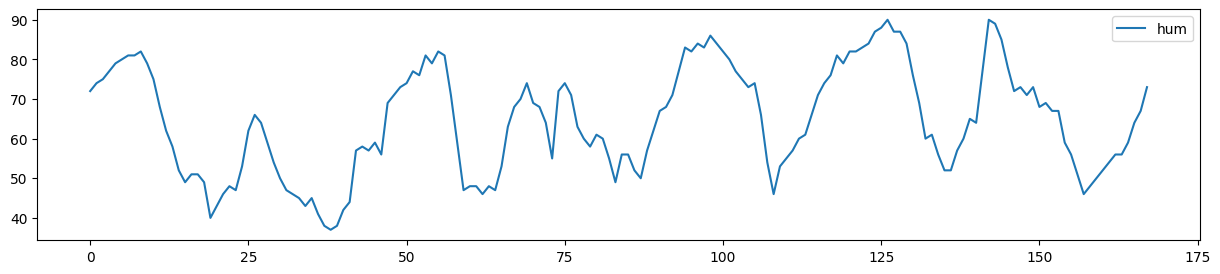

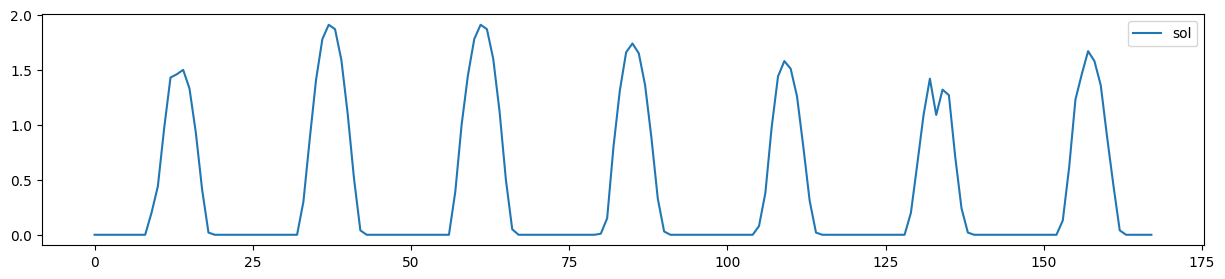

In [6]:
for i in range(5):
    dff.iloc[:24*7,[i+1]].plot(figsize=(15, 3));

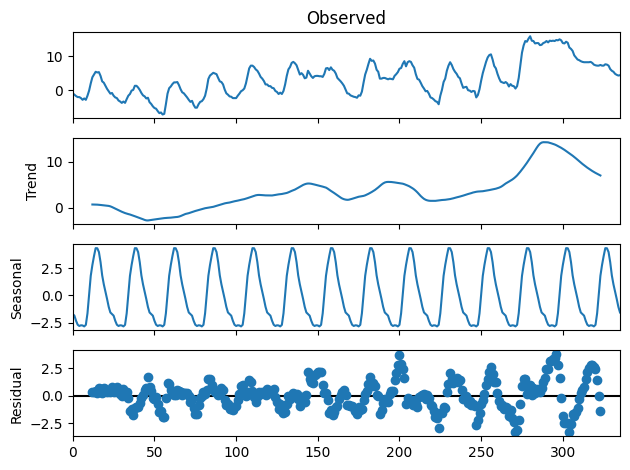

In [192]:
from statsmodels.tsa.seasonal import seasonal_decompose

#ts = pd.Series(dff.iloc[:24*7,[0+1]].values, index=pd.date_range(start='2024-01-01', periods=24, freq='H'))

# 분해 수행 (Additive 모델, 주기성 주기=24시간)
result = seasonal_decompose(dff.iloc[:24*14,[0+1]].values, model='additive', period=24)

# 시각화
result.plot()
#plt.suptitle("시계열 분해 결과 (추세 + 계절 + 잡음)")
plt.tight_layout()
plt.show()

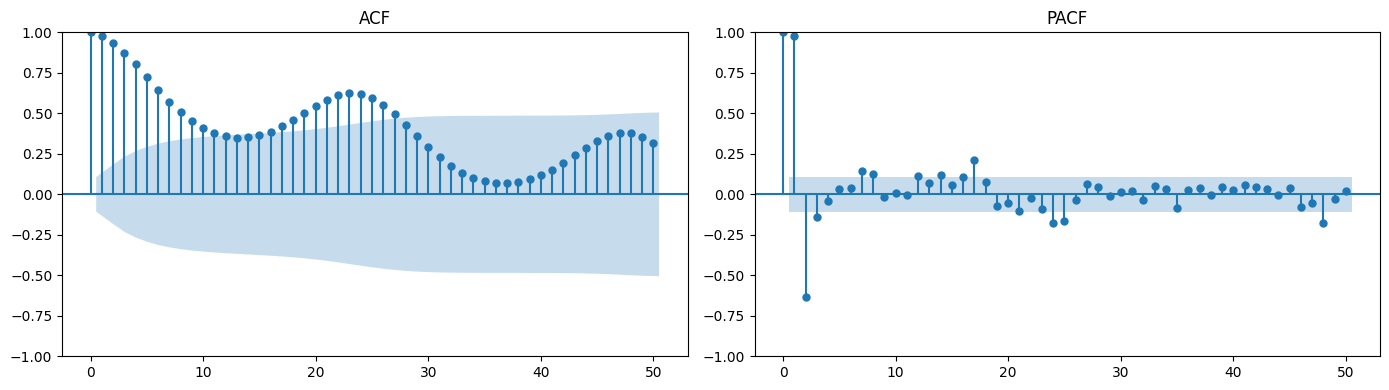

In [197]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts=dff.iloc[:24*14,[0+1]].values
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts, lags=50, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(ts, lags=50, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

In [52]:
dff.iloc[:,1:].corr()

,tem,rain,wind,hum,sol
tem,1.000000,0.088878,-0.015775,0.068916,0.325390
rain,0.088878,1.000000,0.044328,0.201968,-0.080005
wind,-0.015775,0.044328,1.000000,-0.289456,0.270193
hum,0.068916,0.201968,-0.289456,1.000000,-0.571050
sol,0.325390,-0.080005,0.270193,-0.571050,1.000000


---
# VAR모형 적합

- $X$ : y의 과거값 및 외생변수, 길이는 24*14
- $y$ : 예측하고자 하는 일사량, 길이는 24

`-` M1 : 온도와 일사량

In [75]:
X = dff.iloc[:24*14,[1,-1]]
y = dff.iloc[24*14:24*15,1:]

In [116]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
# 데이터: y, x1~x4가 있는 시계열 데이터프레임
# 인덱스는 datetime이어야 함
# df = pd.read_csv("your_data.csv", index_col=0, parse_dates=True)

# 1. 정상성 검사 및 필요시 차분 (여기선 생략, 필요시 추가해줘)

# 2. VAR 모형 적합
model = VAR(X)

# 3. 시차 선택
lag_result = model.select_order(maxlags=48)
print("AIC 기준 최적 시차:", lag_result.selected_orders['aic'])
lag = lag_result.selected_orders['aic']

# 4. VAR 모델 적합
results = model.fit(lag)
#print(results.summary())

AIC 기준 최적 시차: 24


In [77]:
n_forecast = 24
forecast_input = X.values[-lag:]  # 최근 lag만큼의 데이터 사용
forecast1 = results.forecast(y=forecast_input, steps=n_forecast)

---
`-` M2 : 습도와 일사량

In [117]:
X = dff.iloc[:24*14,[-2,-1]]
#y = dff.iloc[24*7:24*8,1:]

model = VAR(X)

# 3. 시차 선택
lag_result = model.select_order(maxlags=24)
print("AIC 기준 최적 시차:", lag_result.selected_orders['aic'])
lag = lag_result.selected_orders['aic']

# 4. VAR 모델 적합
results = model.fit(lag)
results.summary()

AIC 기준 최적 시차: 24


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Mar, 2025
Time:                     16:09:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.604405
Nobs:                     312.000    HQIC:                  -1.31021
Log likelihood:          -509.723    FPE:                   0.169509
AIC:                     -1.78009    Det(Omega_mle):        0.126616
--------------------------------------------------------------------
Results for equation hum
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           6.524909         3.046199            2.142           0.032
L1.hum          1.163220         0.063398           18.348           0.000
L1.sol         -5.201450         2.448752           -2.124           0.034
L2.hum     

In [118]:
n_forecast = 24
forecast_input = X.values[-lag:]  # 최근 lag만큼의 데이터 사용
forecast2 = results.forecast(y=forecast_input, steps=n_forecast)

`-` 풍속

In [119]:
X = dff.iloc[:24*14,[-3,-1]]
#y = dff.iloc[24*7:24*8,1:]

model = VAR(X)

# 3. 시차 선택
lag_result = model.select_order(maxlags=24)
print("AIC 기준 최적 시차:", lag_result.selected_orders['aic'])
lag = lag_result.selected_orders['aic']

# 4. VAR 모델 적합
results = model.fit(lag)
results.summary()

n_forecast = 24
forecast_input = X.values[-lag:]  # 최근 lag만큼의 데이터 사용
forecast2_ = results.forecast(y=forecast_input, steps=n_forecast)

AIC 기준 최적 시차: 24


`-` 강수량

In [120]:
X = dff.iloc[:24*14,[-4,-1]]
#y = dff.iloc[24*7:24*8,1:]

model = VAR(X)

# 3. 시차 선택
lag_result = model.select_order(maxlags=24)
print("AIC 기준 최적 시차:", lag_result.selected_orders['aic'])
lag = lag_result.selected_orders['aic']

# 4. VAR 모델 적합
results = model.fit(lag)
results.summary()

n_forecast = 24
forecast_input = X.values[-lag:]  # 최근 lag만큼의 데이터 사용
forecast3_ = results.forecast(y=forecast_input, steps=n_forecast)

AIC 기준 최적 시차: 24


---
`-` M3 : AR 모형 일사량만 이용

In [84]:

from statsmodels.tsa.ar_model import AutoReg

# 예시: y 시계열 데이터프레임 (datetime index 권장)
# df = pd.read_csv("your_data.csv", index_col=0, parse_dates=True)
# y = df['y']
y_ = dff.iloc[:24*14,[-1]]# 시계열 형태로 가져오기

# 1. 시차(p) 설정 또는 자동 선택
p = 24  # 최근 24시간을 기반으로 다음을 예측한다고 가정

# 2. AR 모형 적합
model = AutoReg(y_, lags=p, old_names=False)
results = model.fit()

# 3. 다음 24시간 예측
forecast3 = results.predict(start=len(y), end=len(y)+23)

---
`-` 예측 결과 및 plot

온도, 일사량 0.056435254698793375
습도, 일사량 0.015137502304981185
풍속, 일사량 0.029656574378202627
강수량, 일사량 0.03955956625409462
일사량 0.4978167974666636


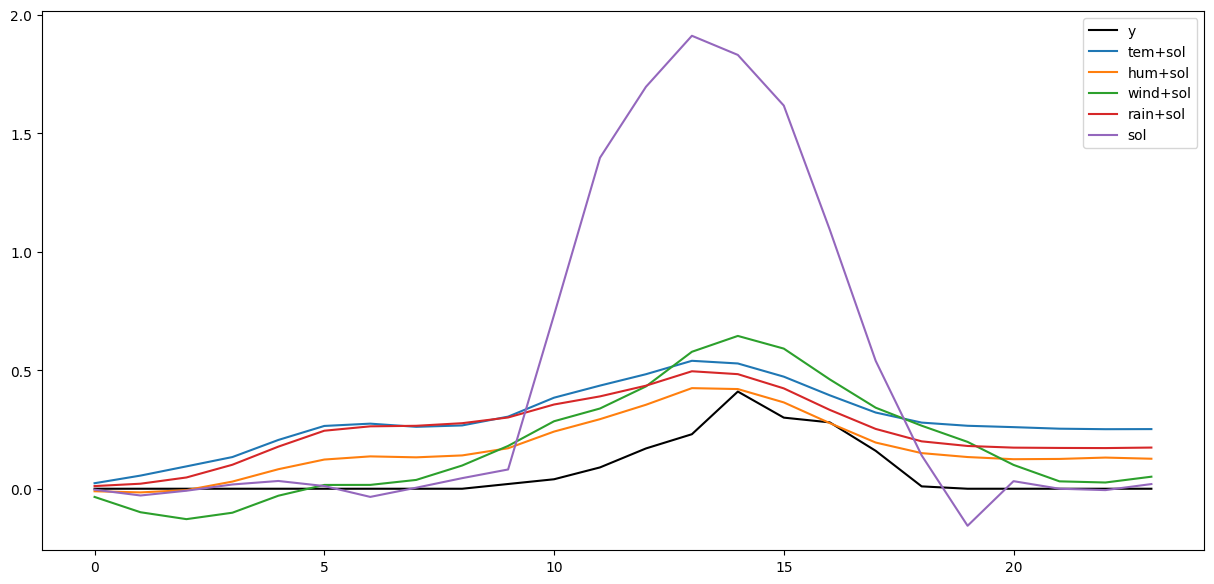

In [121]:
print('온도, 일사량',mean_squared_error(y['sol'].values,forecast1[:,1]))
print('습도, 일사량',mean_squared_error(y['sol'].values,forecast2[:,1]))
print('풍속, 일사량',mean_squared_error(y['sol'].values,forecast2_[:,1]))
print('강수량, 일사량',mean_squared_error(y['sol'].values,forecast3_[:,1]))

print('일사량',mean_squared_error(y['sol'].values,forecast3))



plt.figure(figsize = (15,7))
plt.plot(y['sol'].values, label = 'y',color = 'black')
plt.plot(forecast1[:,1],label = 'tem+sol')
plt.plot(forecast2[:,1],label = 'hum+sol')
plt.plot(forecast2_[:,1],label = 'wind+sol')
plt.plot(forecast3_[:,1],label = 'rain+sol')

plt.plot(forecast3.values,label = 'sol')
plt.legend()
plt.show()

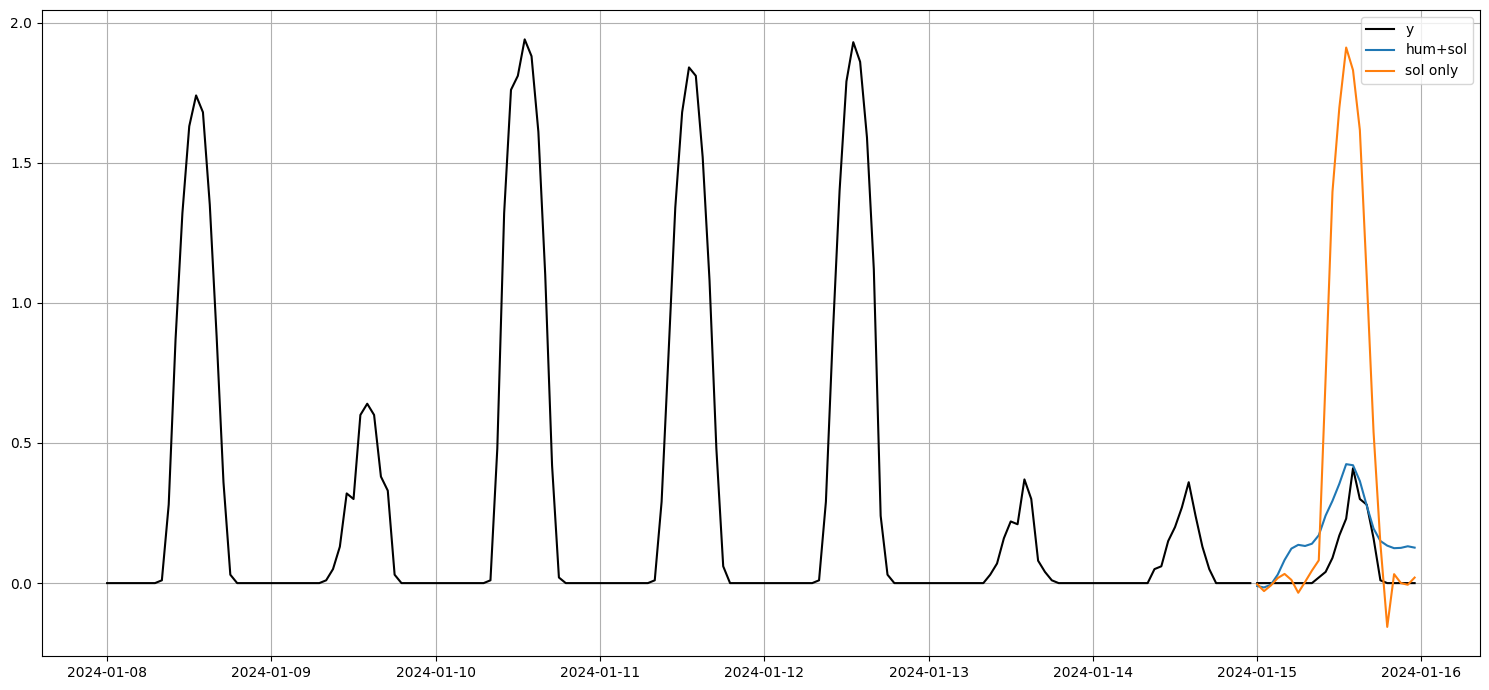

In [198]:
import pandas as pd
import matplotlib.pyplot as plt

# 0. y_ 인덱스가 숫자면 → datetime 인덱스로 바꿔주기
if not isinstance(y_.index[0], pd.Timestamp):
    y_.index = pd.date_range(start='2024-01-01', periods=len(y_), freq='h')

# 1. 예측 구간 인덱스 생성
forecast_index = pd.date_range(start=y_.index[-1] + pd.Timedelta(hours=1), periods=24, freq='h')

# 2. 예측값 시리즈화
sol = pd.Series(y['sol'].values, index=forecast_index)
tem_sol = pd.Series(forecast1[:, 1], index=forecast_index)
hum_sol = pd.Series(forecast2[:, 1], index=forecast_index)
sol_only = pd.Series(forecast3.values.flatten(), index=forecast_index)

# 3. 플롯
plt.figure(figsize=(15, 7))
plt.plot(y_[-24*7:],color = 'black')
plt.plot(sol, label = 'y',color = 'black')
#plt.plot(tem_sol, label='tem+sol')
plt.plot(hum_sol, label='hum+sol')
plt.plot(sol_only, label='sol only')
plt.legend()
#plt.title("과거 + 예측 시계열")
#plt.xlabel("시간")
plt.grid(True)
plt.tight_layout()
plt.show()



---
# Granger 인과검정

`-` 각 변수 상관관계

`-` 풀모형에서 Granger 인과검정

- H0 : 외생변수 전체는 Granger 인과하지 않다
- H1 : 외생변수 중 어떤 하나 이상의 변수가 Granger 인과하다

In [128]:
from statsmodels.tsa.api import VAR

# 1. 전체 시계열 데이터 사용 (예: df = ['y', 'x1', 'x2', 'x3', 'x4'])

X = dff.iloc[:24*14,1:]
model = VAR(X)
results = model.fit(maxlags=24,ic='aic')  # 자동 시차 선택

gc_test = results.test_causality(caused='sol', causing=['tem', 'rain', 'wind', 'hum'], kind='f')

# 3. 결과 요약
print(gc_test.summary())

Granger causality F-test. H_0: ['tem', 'rain', 'wind', 'hum'] do not Granger-cause sol. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.752          1.310   0.000 (68, 1165)
------------------------------------------------


In [182]:
X = dff.iloc[:24*14,[1,-1]]
model = VAR(X)
results = model.fit(maxlags=24,ic='aic') 
gc_test = results.test_causality(caused='sol', causing=['tem'], kind='f')

# 3. 결과 요약
print(gc_test.summary())

Granger causality F-test. H_0: tem does not Granger-cause sol. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.069          1.538   0.376 (24, 526)
-----------------------------------------------


In [181]:
X = dff.iloc[:24*14,[2,-1]]
model = VAR(X)
results = model.fit(maxlags=24,ic='aic') 
gc_test = results.test_causality(caused='sol', causing=['rain'], kind='f')

# 3. 결과 요약
print(gc_test.summary())

Granger causality F-test. H_0: rain does not Granger-cause sol. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.514          1.538   0.056 (24, 526)
-----------------------------------------------


In [145]:
X = dff.iloc[:24*14,[3,-1]]
model = VAR(X)
results = model.fit(maxlags=24,ic='aic') 
gc_test = results.test_causality(caused='sol', causing=['wind'], kind='f')

# 3. 결과 요약
print(gc_test.summary())

Granger causality F-test. H_0: wind does not Granger-cause sol. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.9938          1.538   0.472 (24, 526)
-----------------------------------------------


In [147]:
X = dff.iloc[:24*14,[4,-1]]
model = VAR(X)
results = model.fit(maxlags=24,ic='aic') 
gc_test = results.test_causality(caused='sol', causing=['hum'], kind='f')

# 3. 결과 요약
print(gc_test.summary())

Granger causality F-test. H_0: hum does not Granger-cause sol. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.9295          1.538   0.561 (24, 526)
-----------------------------------------------


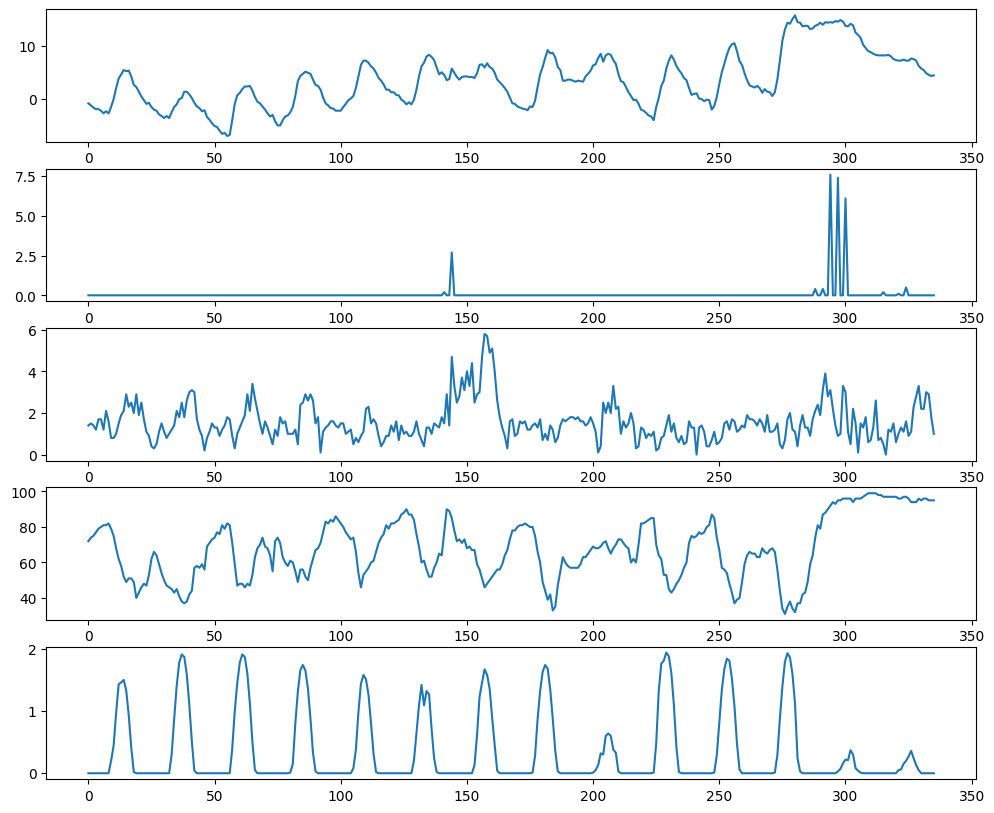

In [224]:
fig, ax = plt.subplots(5,1,figsize=(12,10))
for i in range(5):
    ax[i].plot(dff.iloc[:24*14,i+1])